In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [33]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

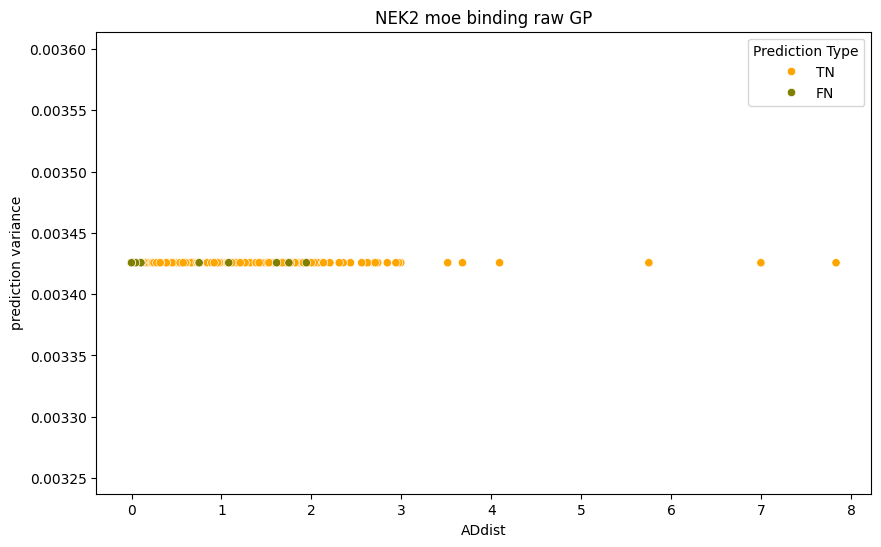

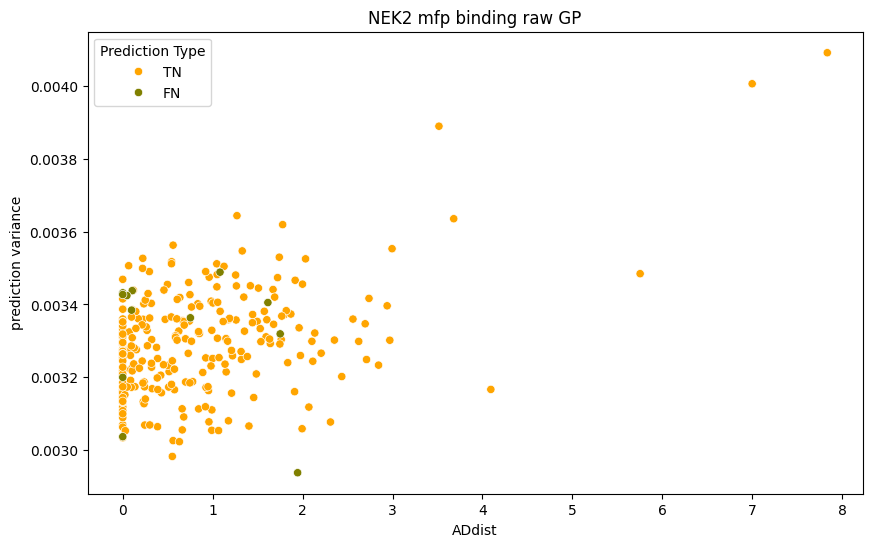

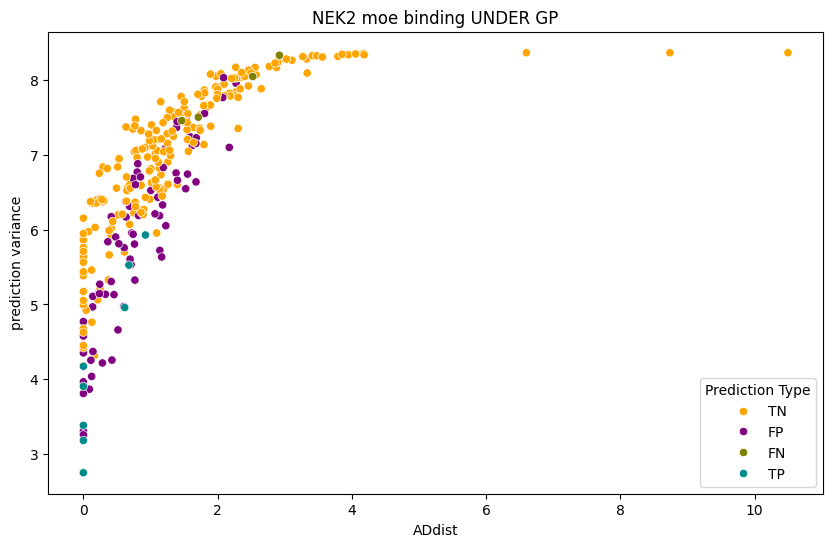

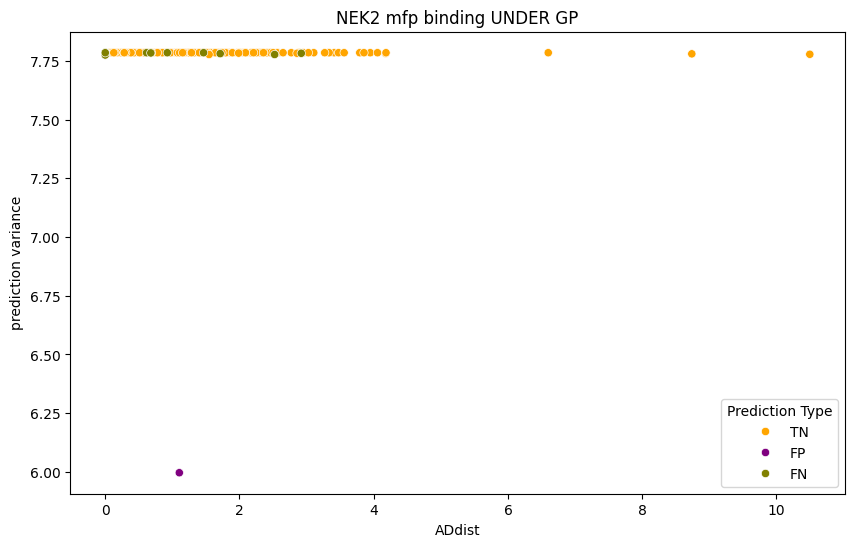

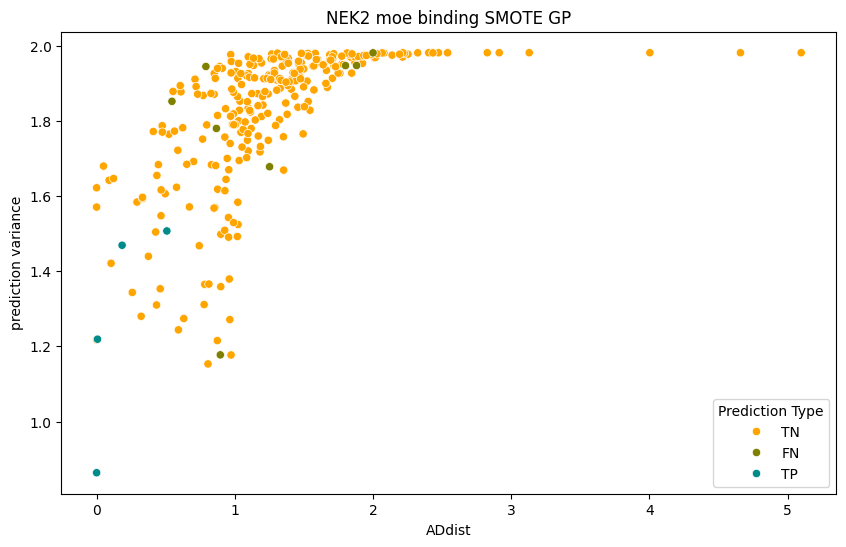

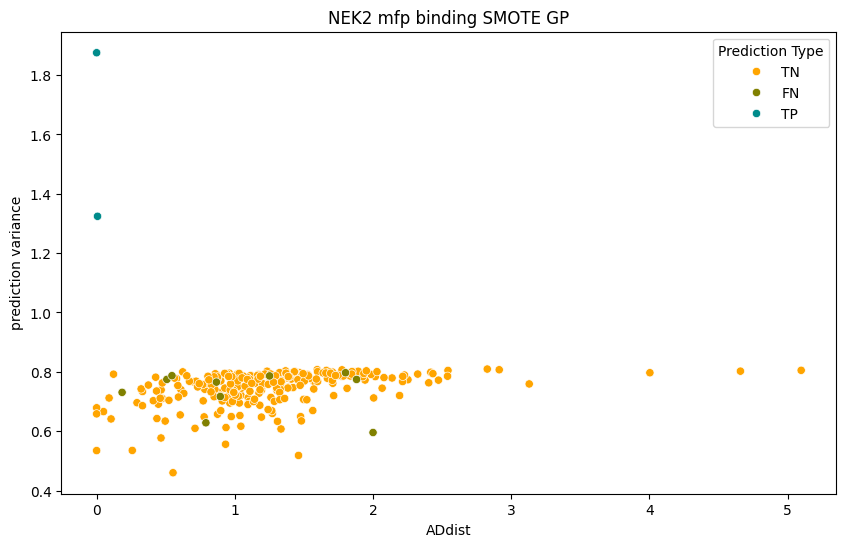

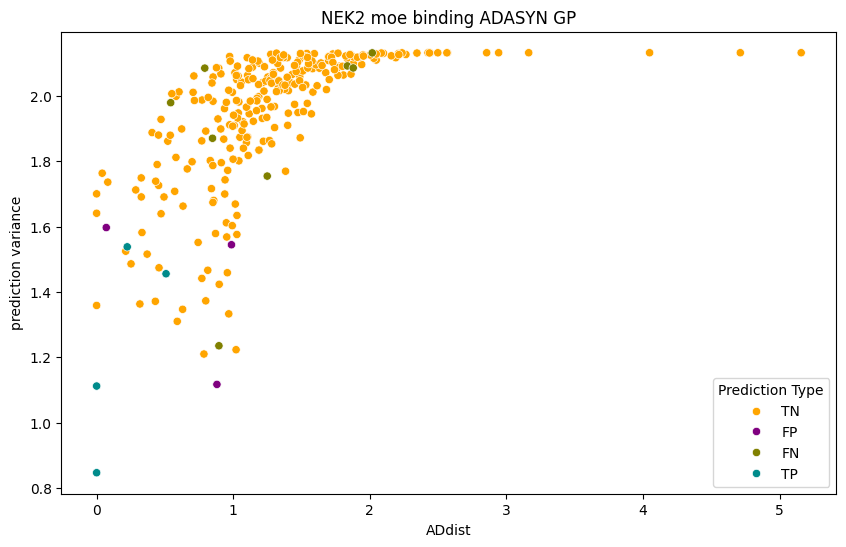

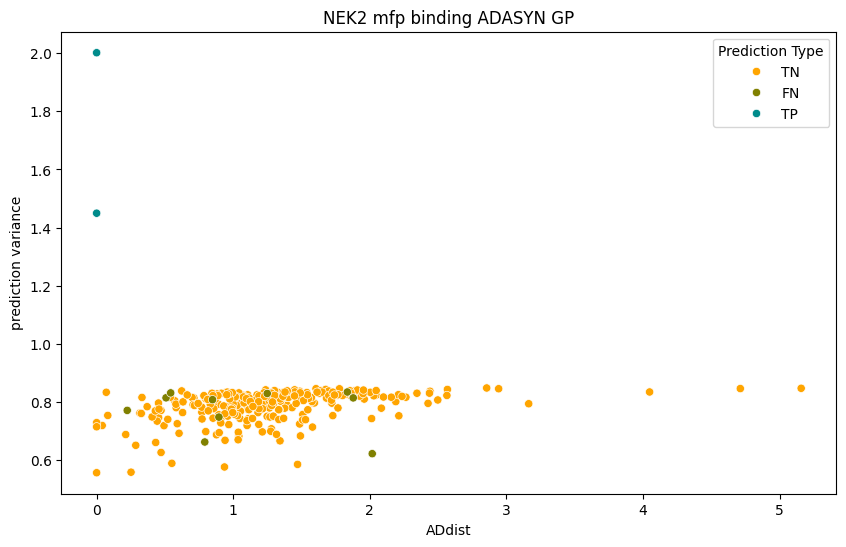

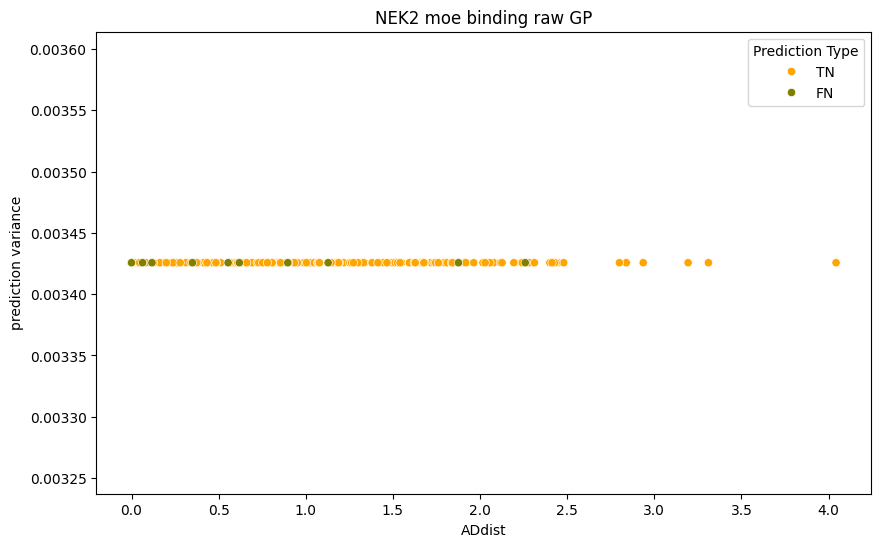

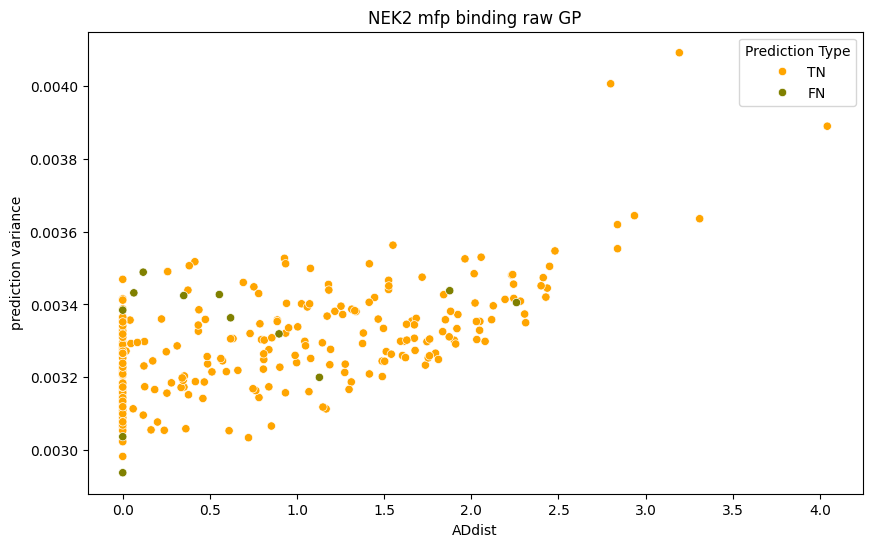

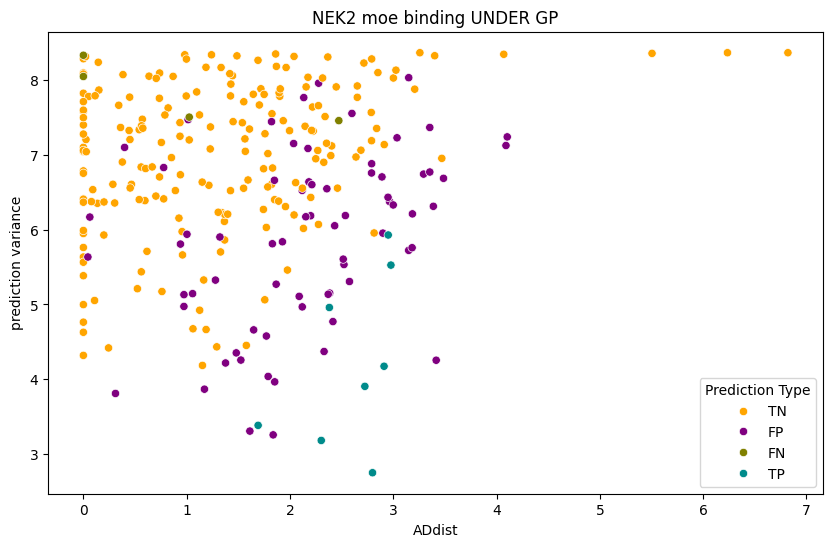

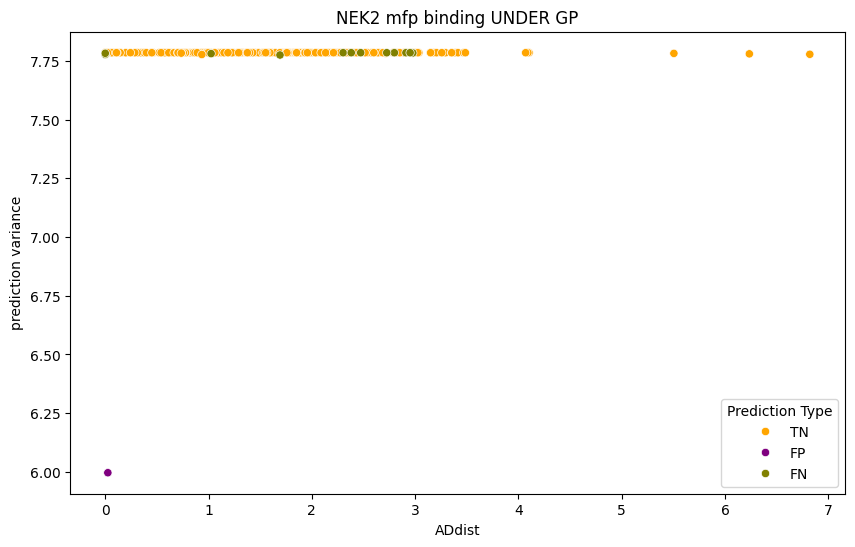

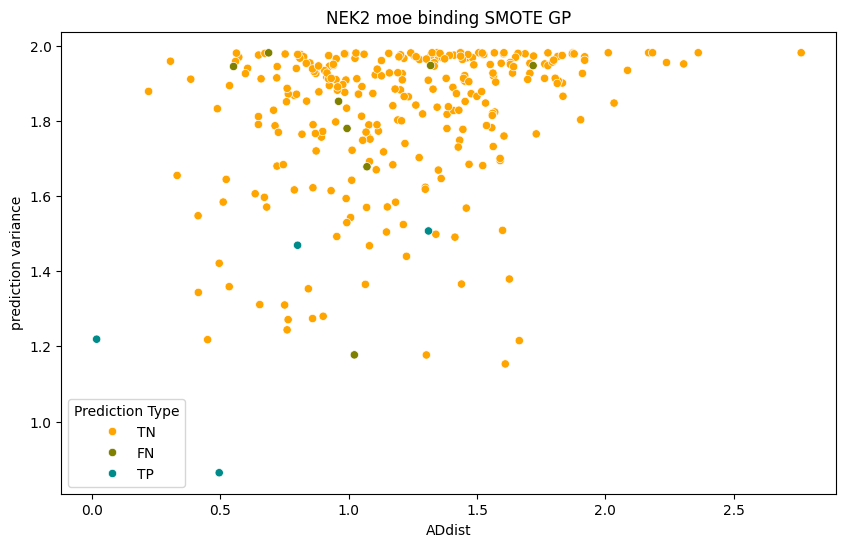

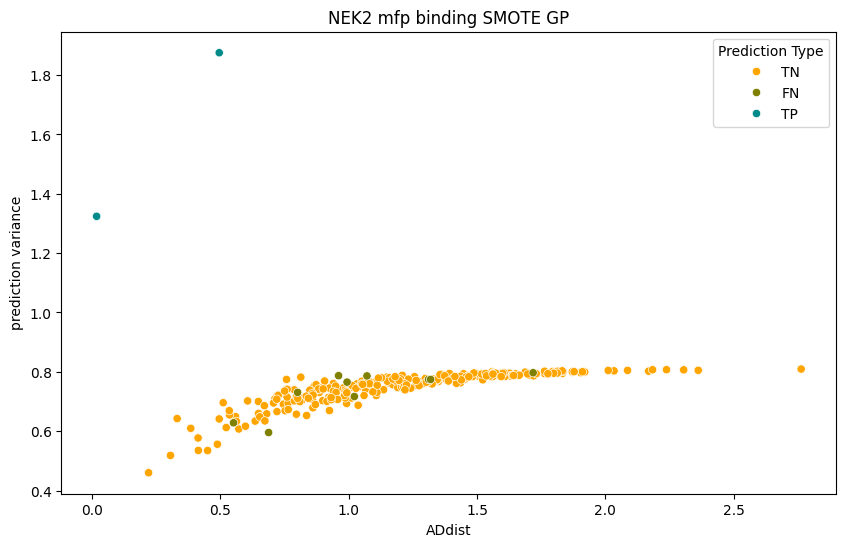

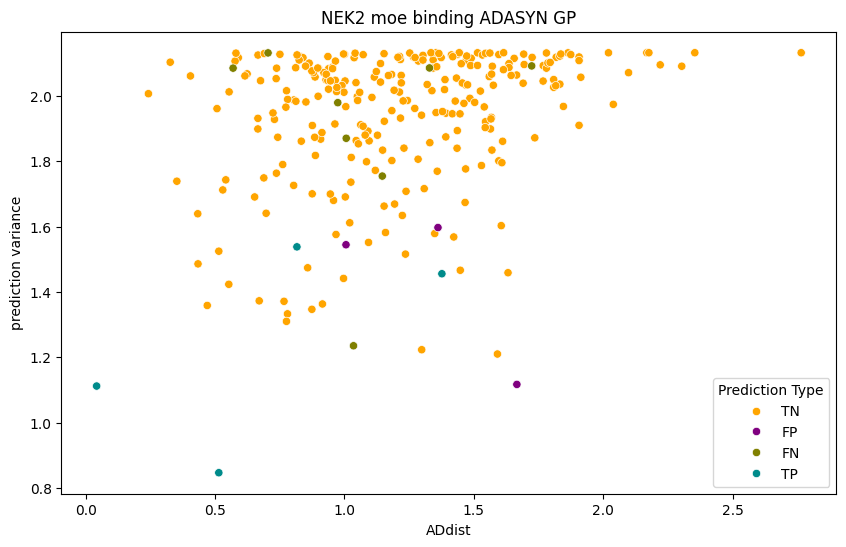

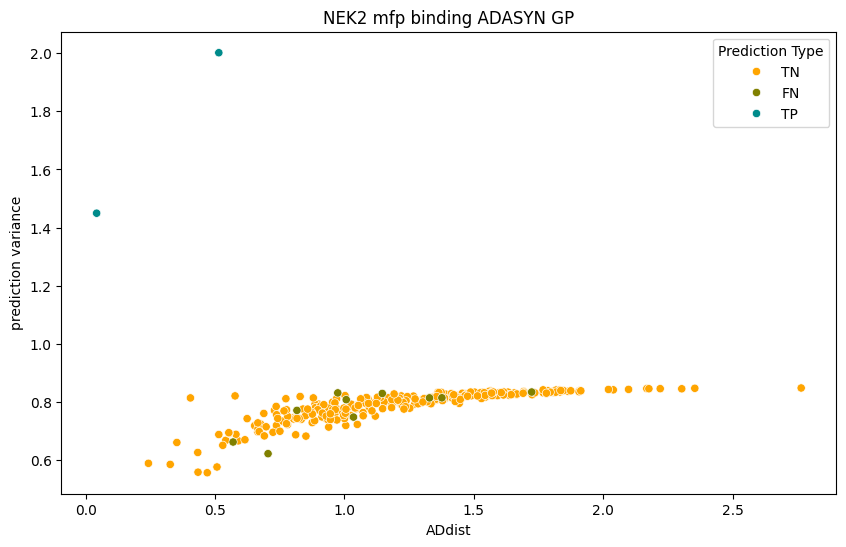

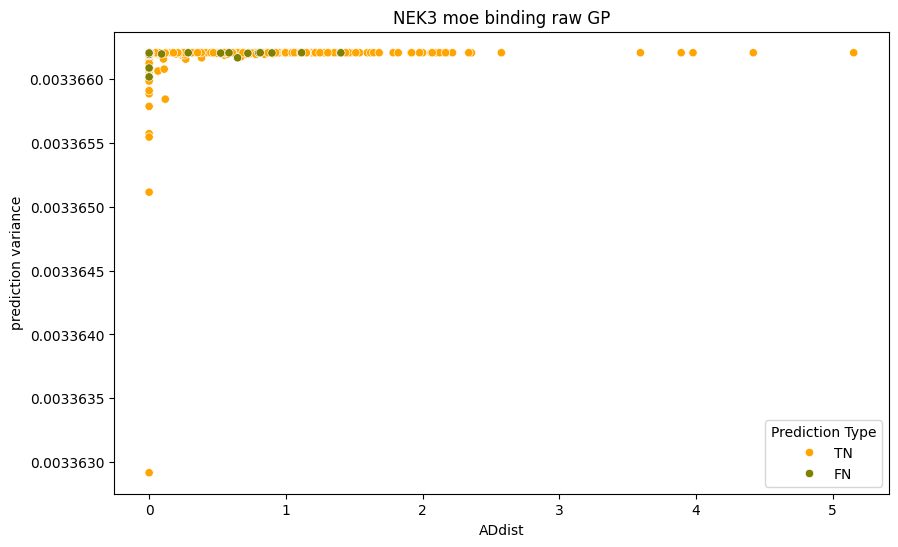

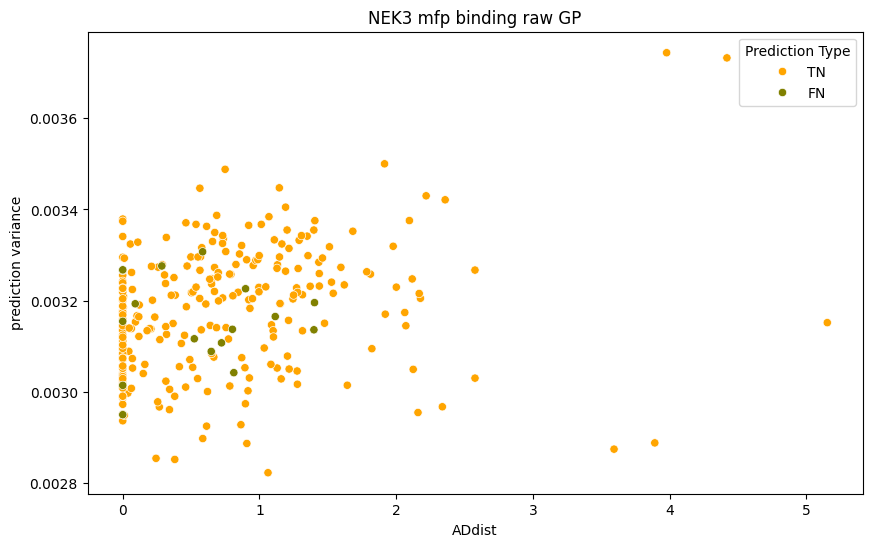

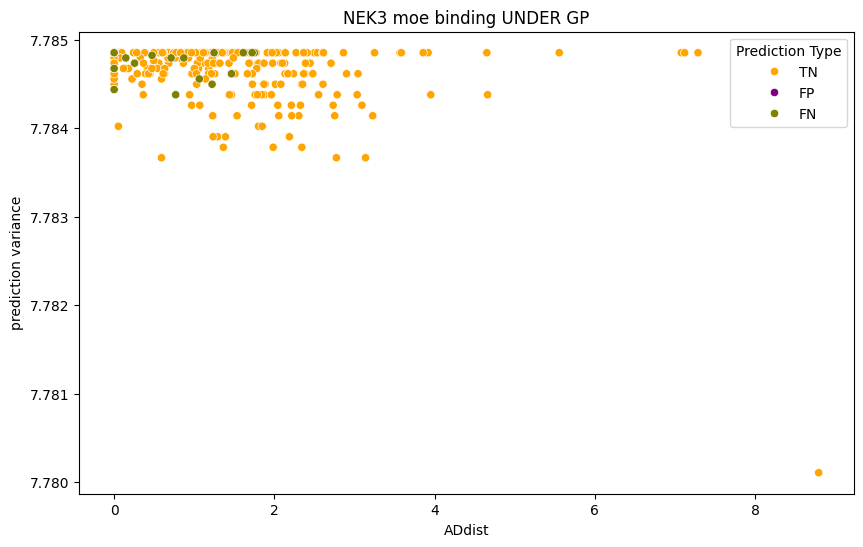

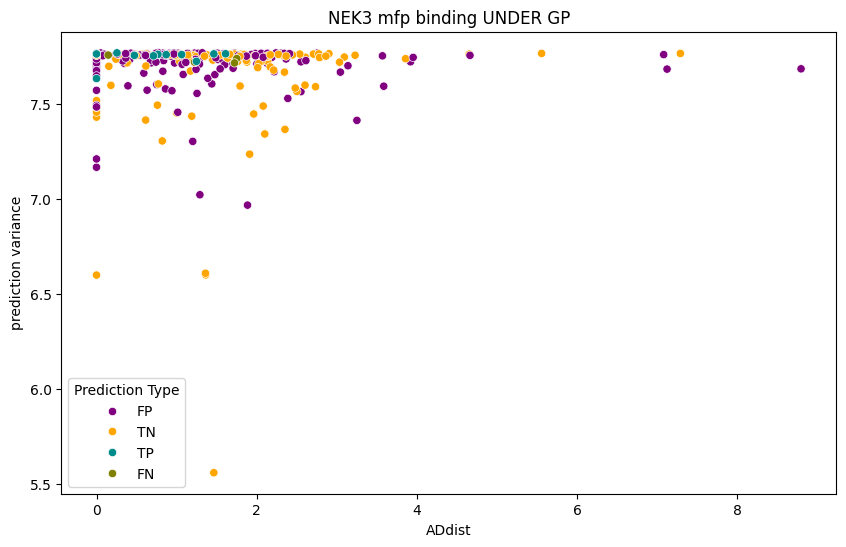

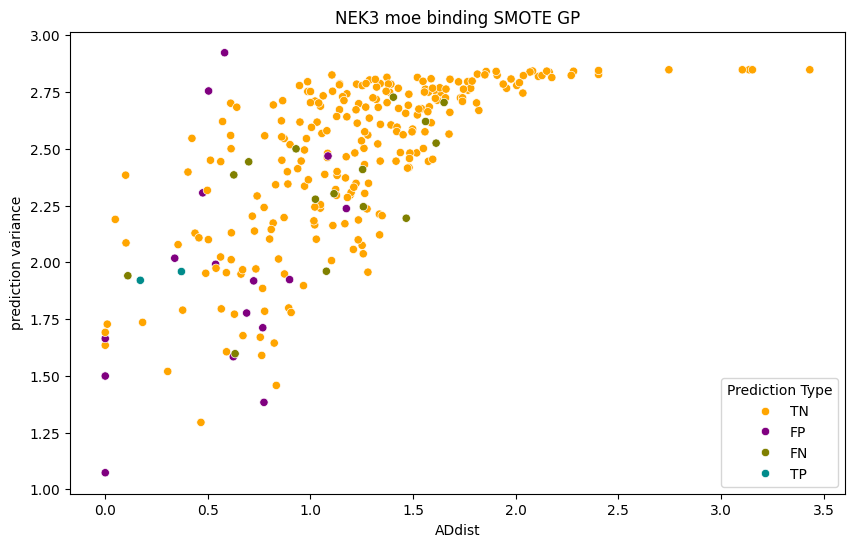

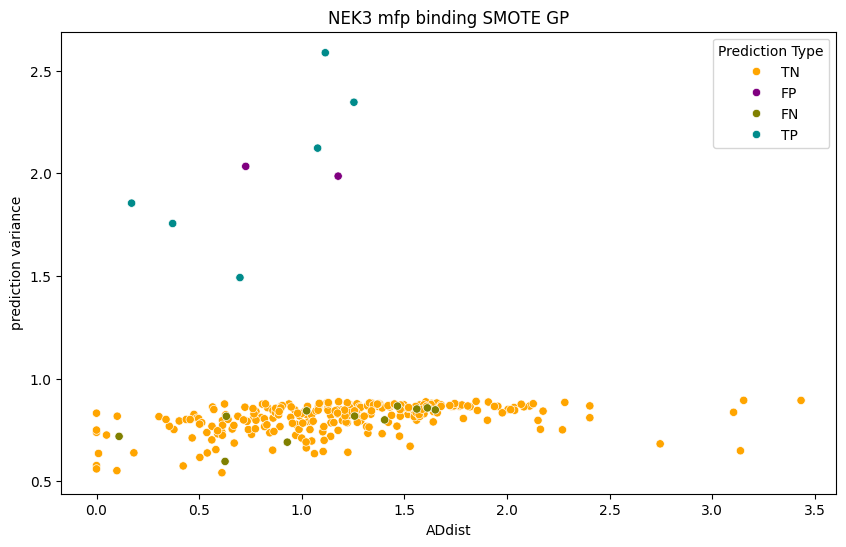

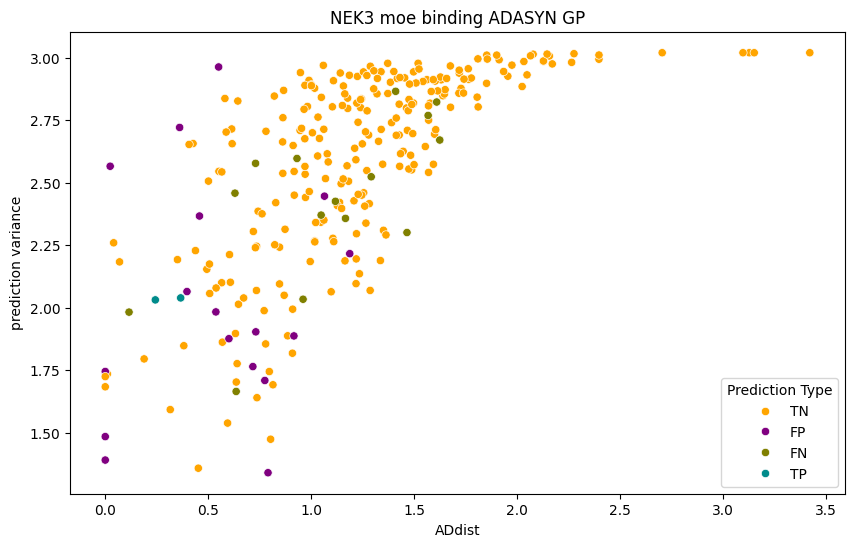

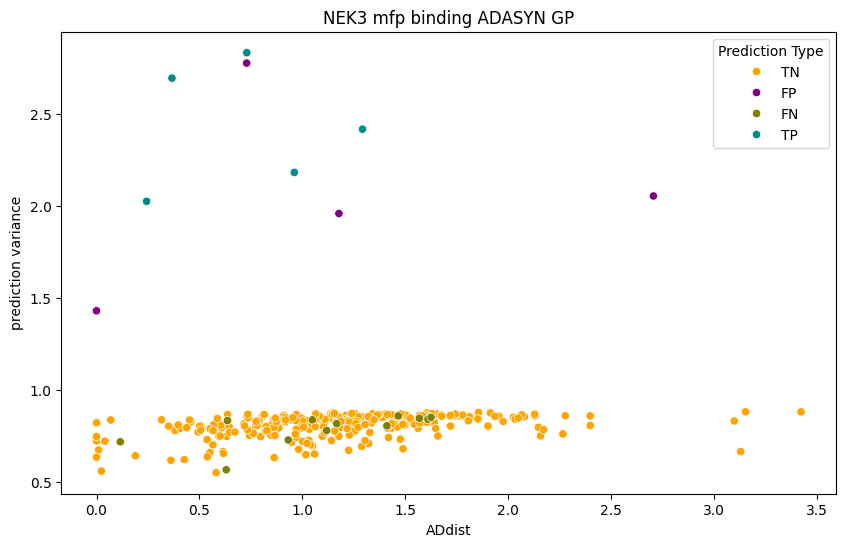

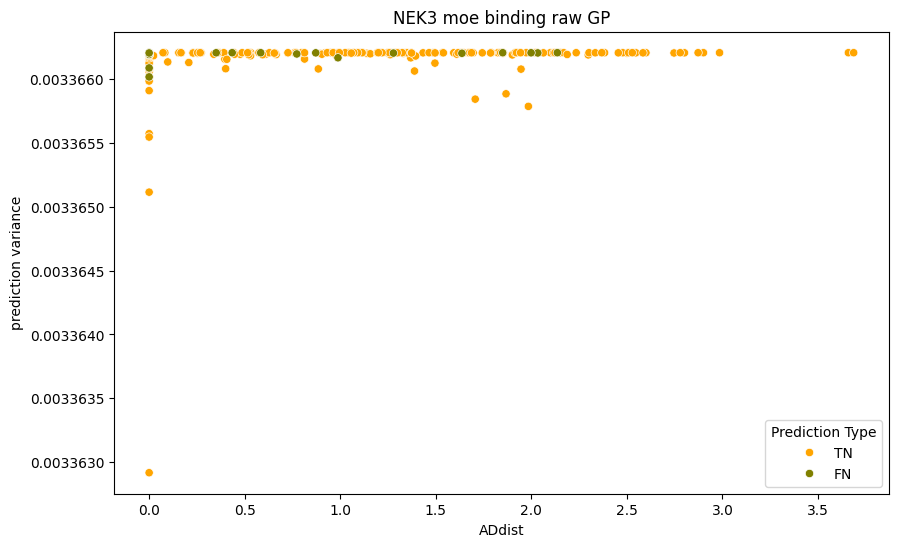

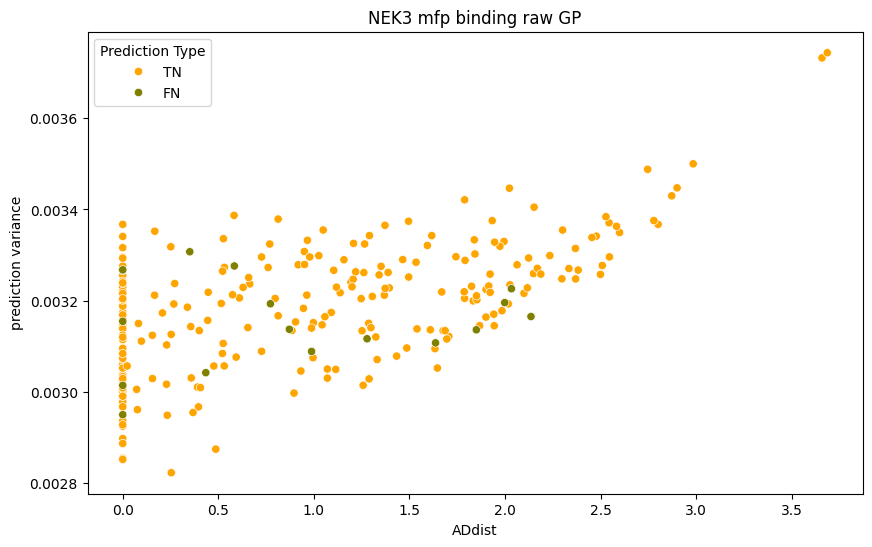

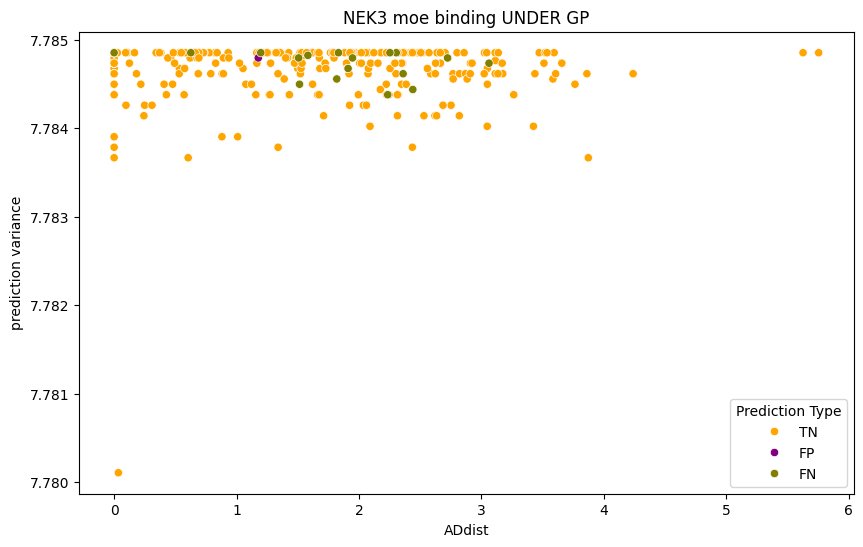

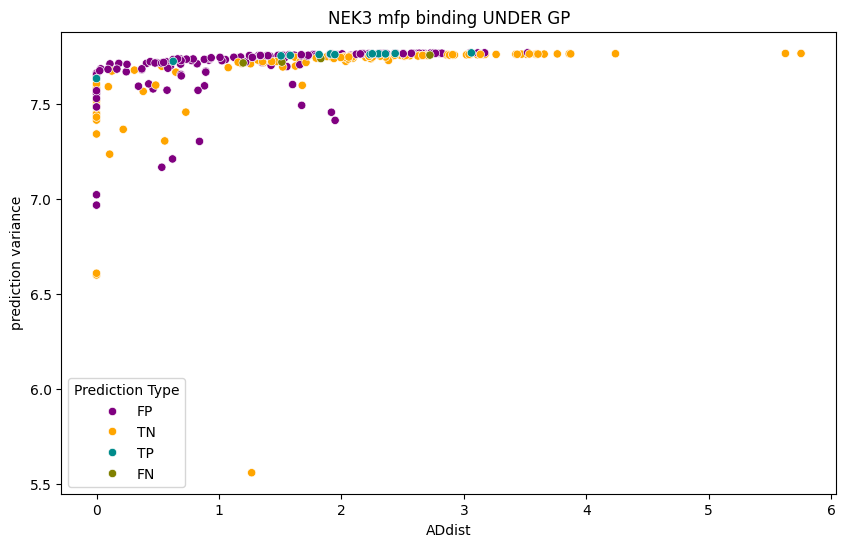

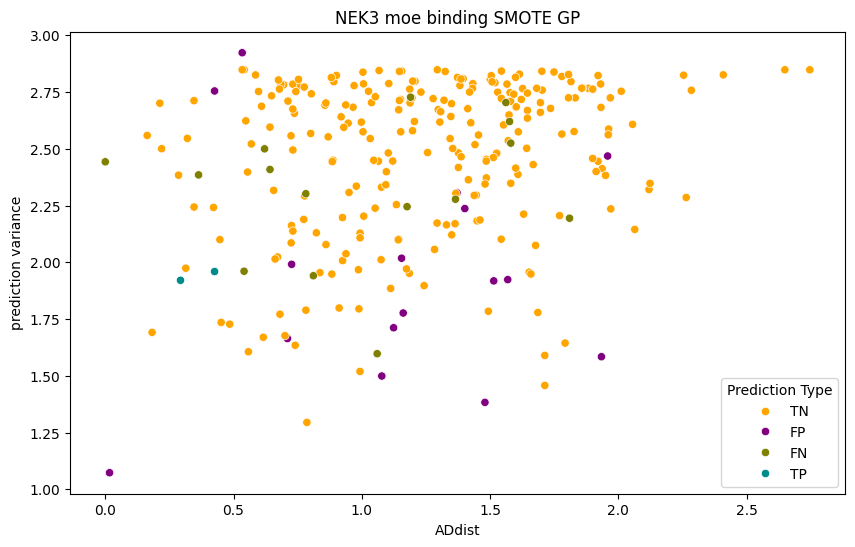

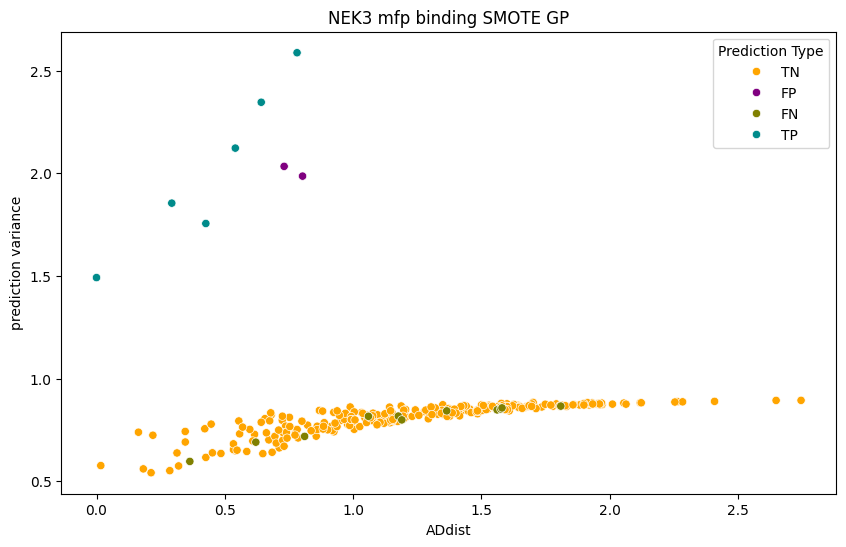

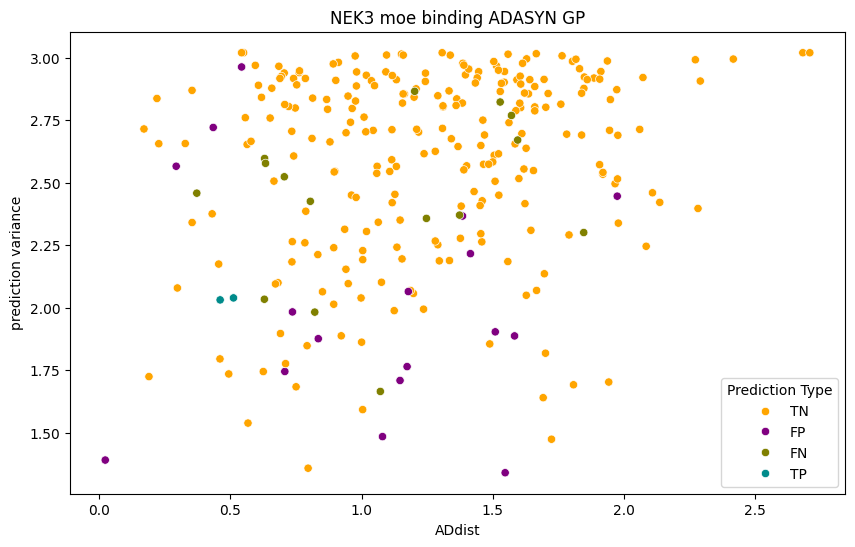

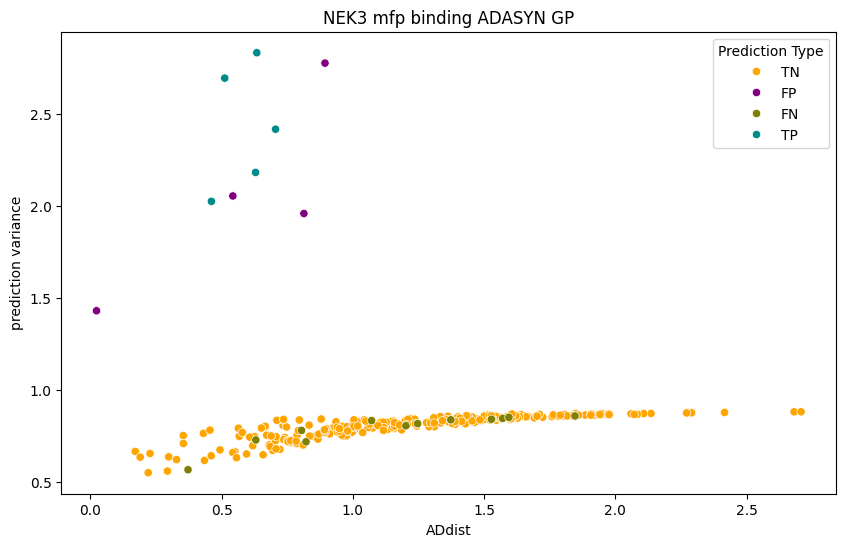

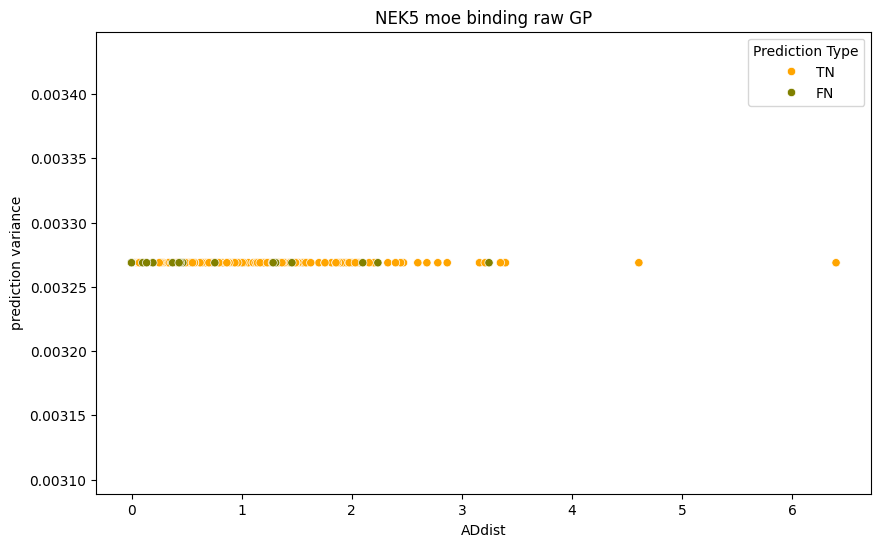

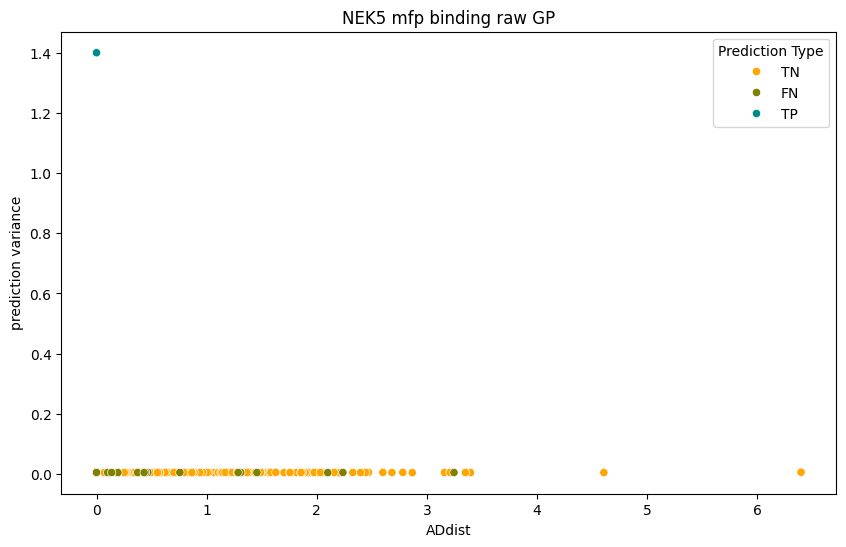

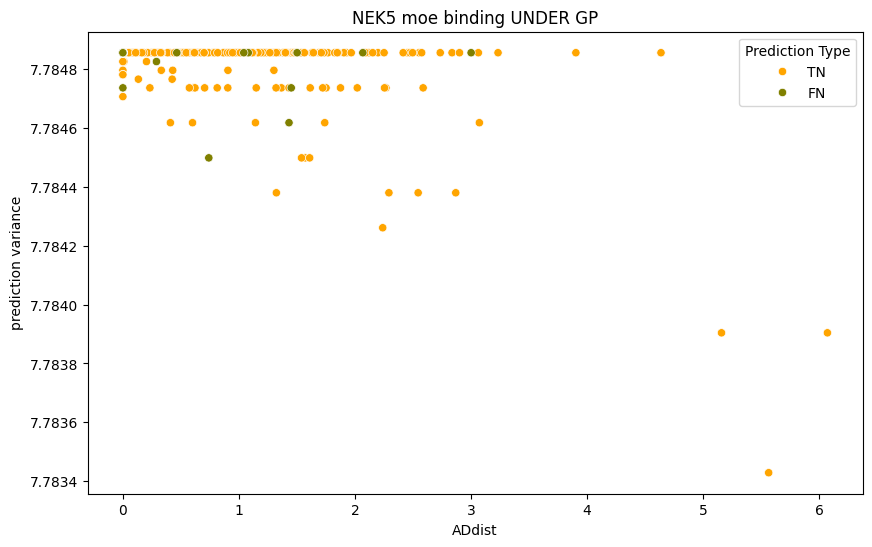

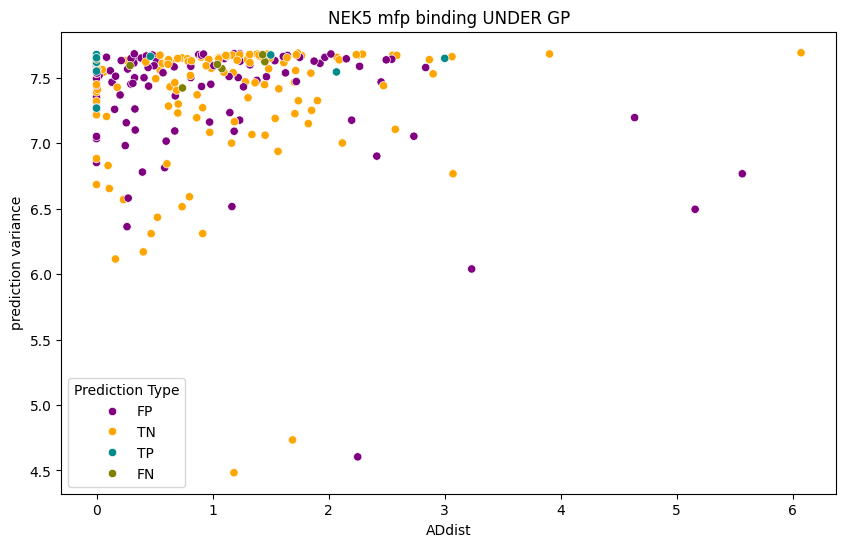

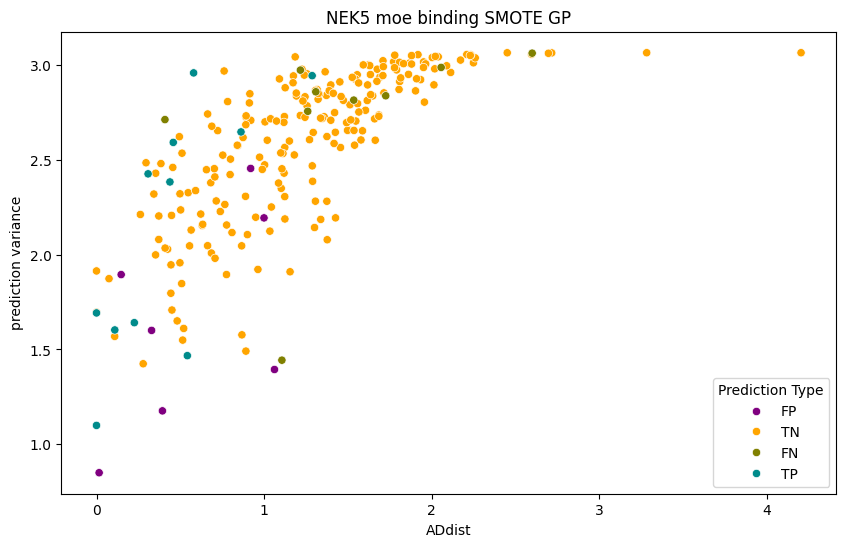

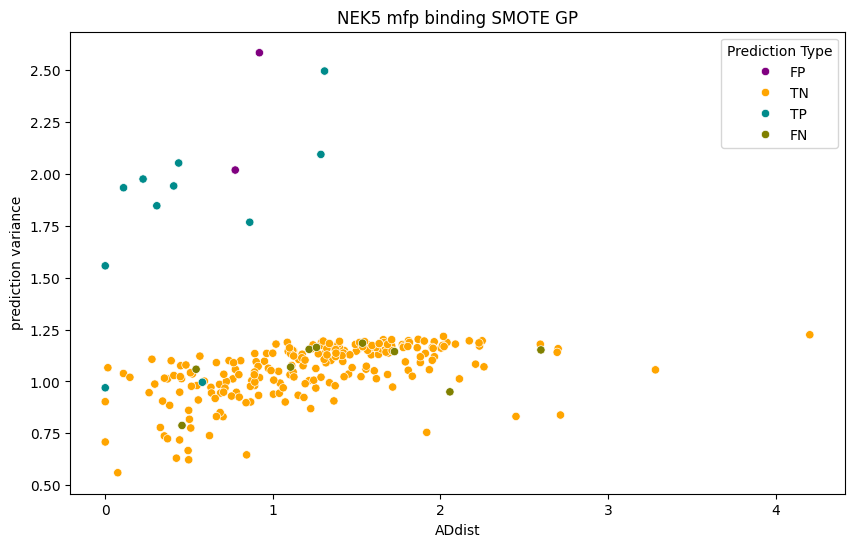

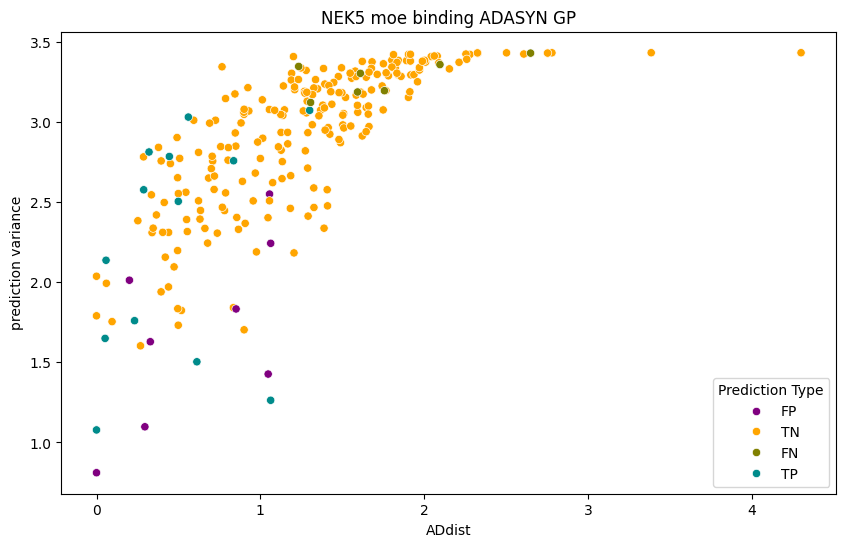

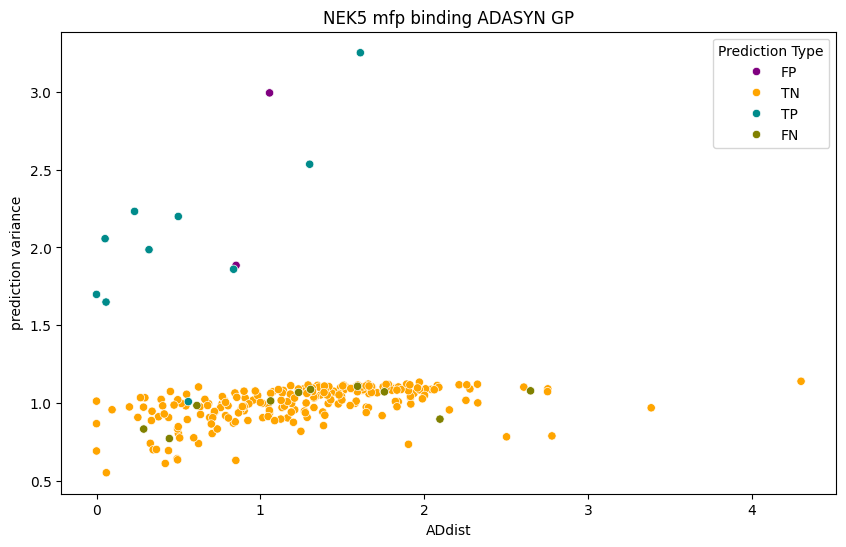

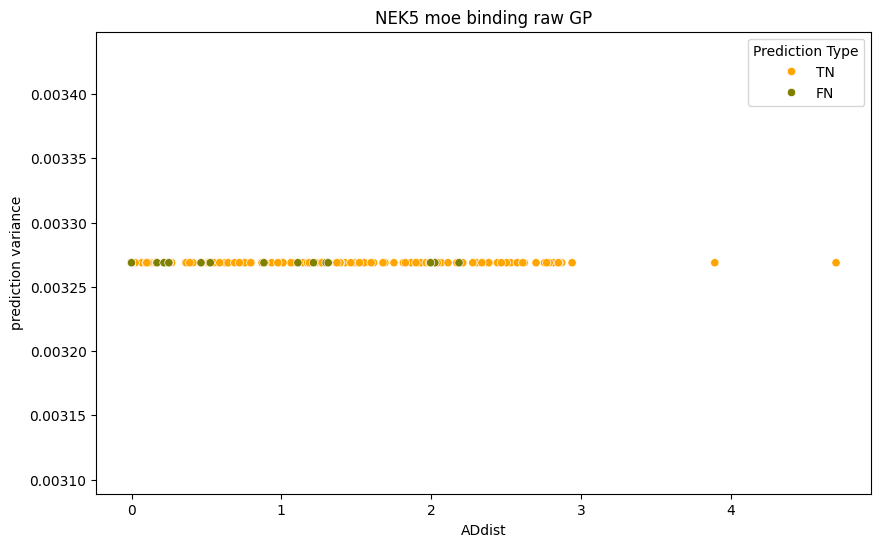

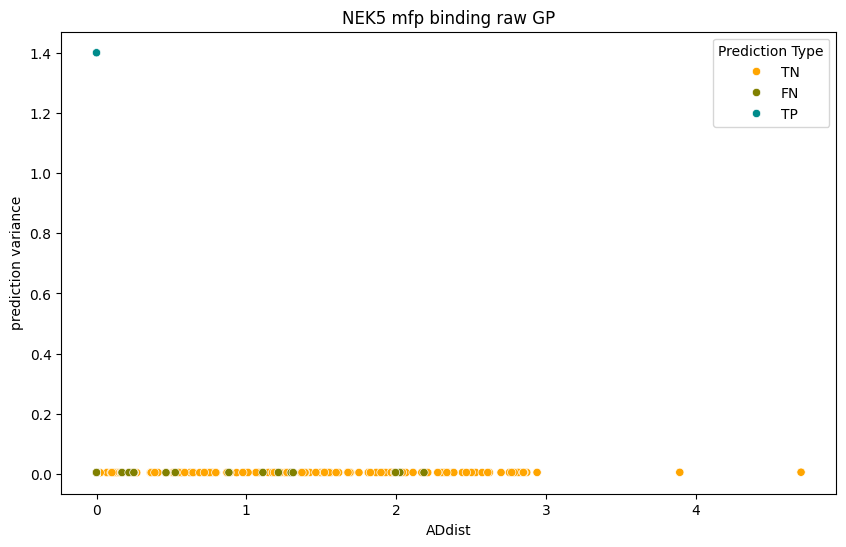

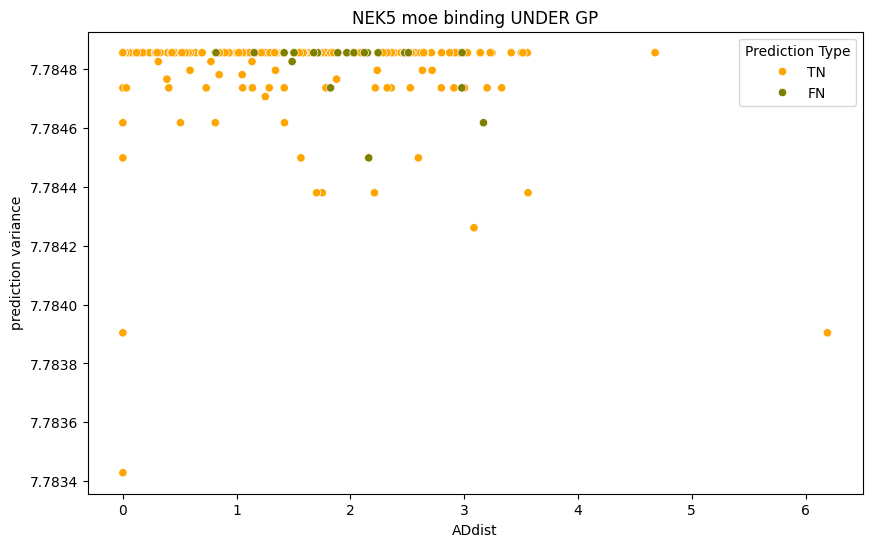

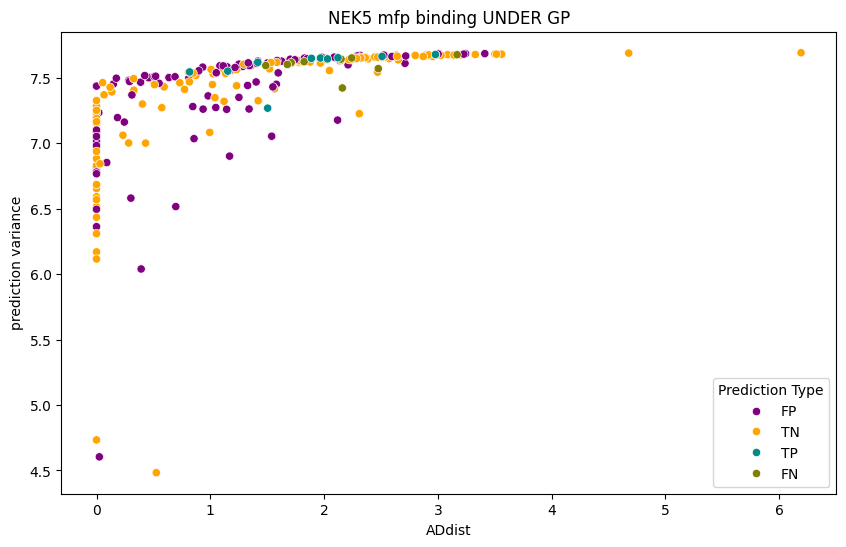

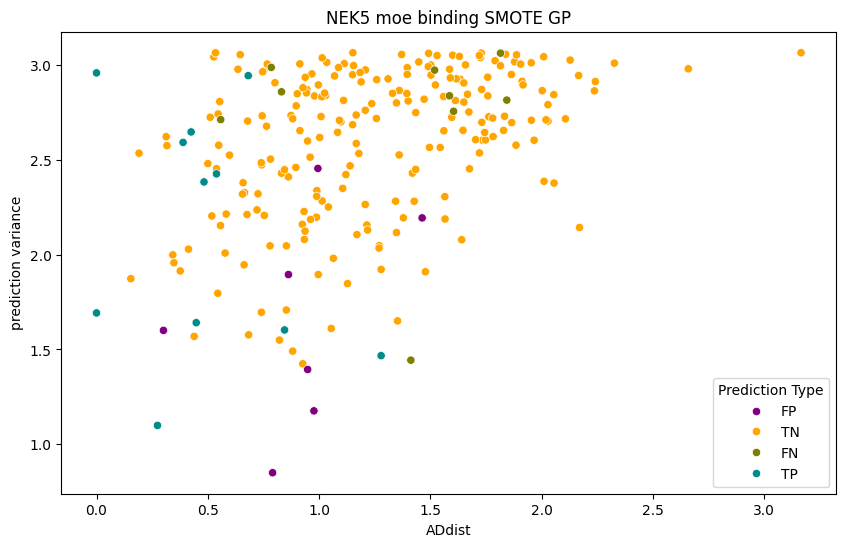

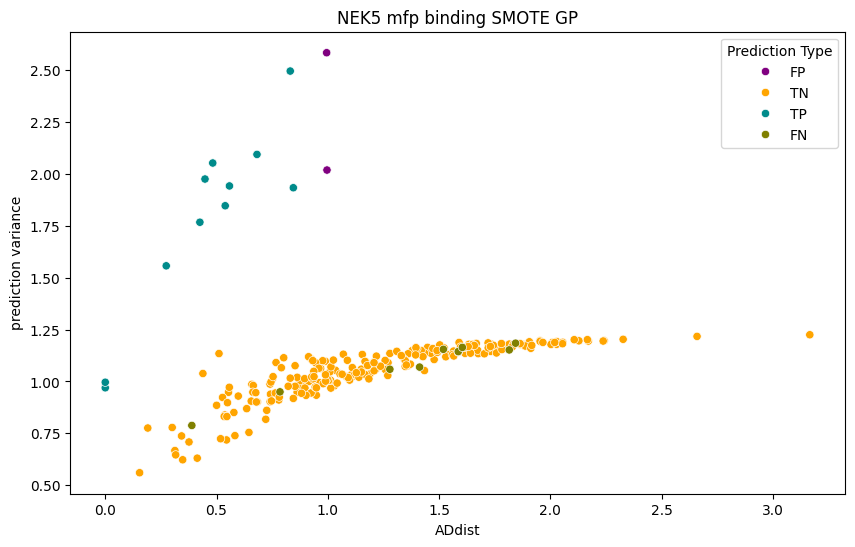

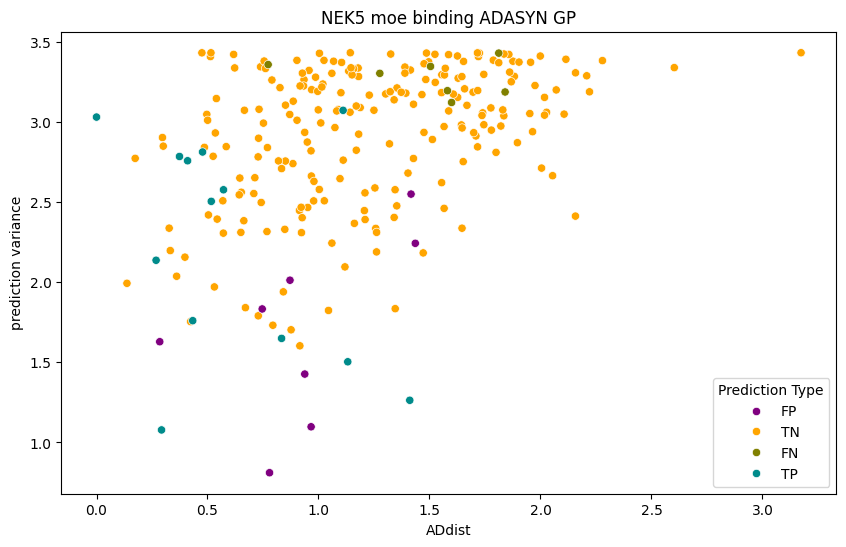

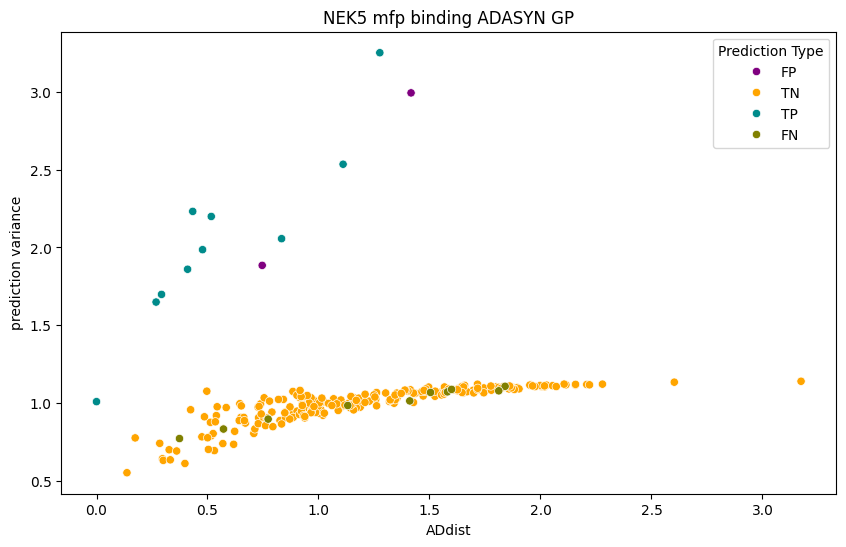

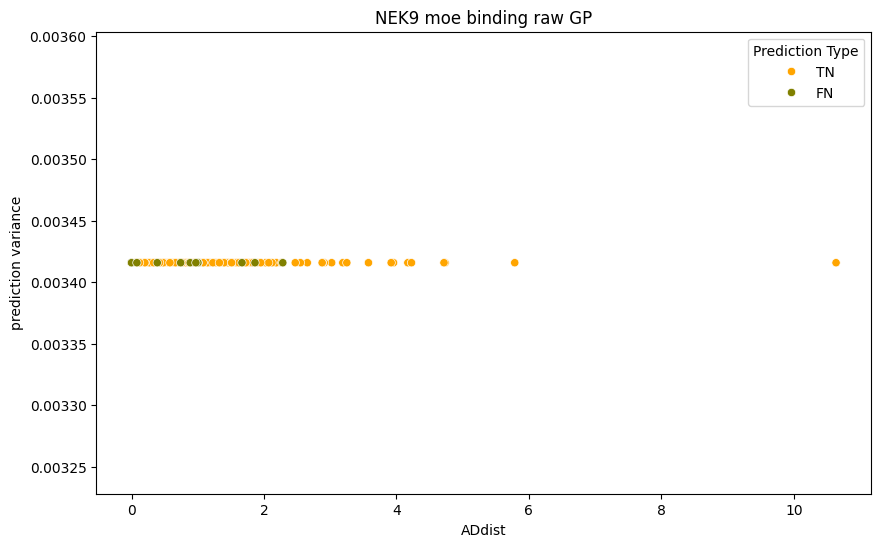

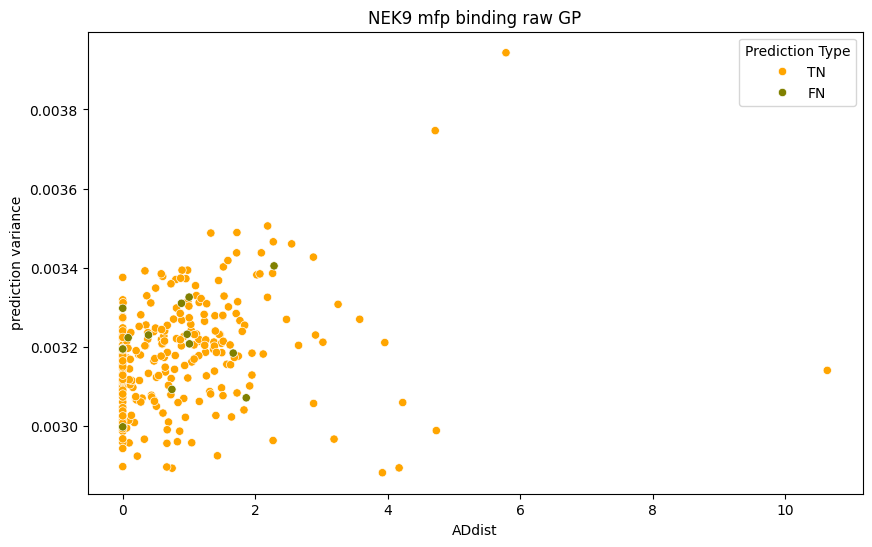

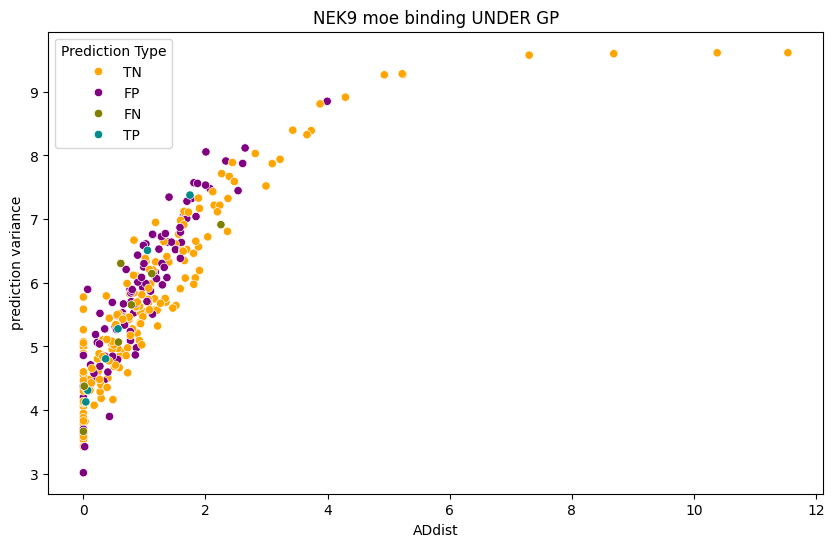

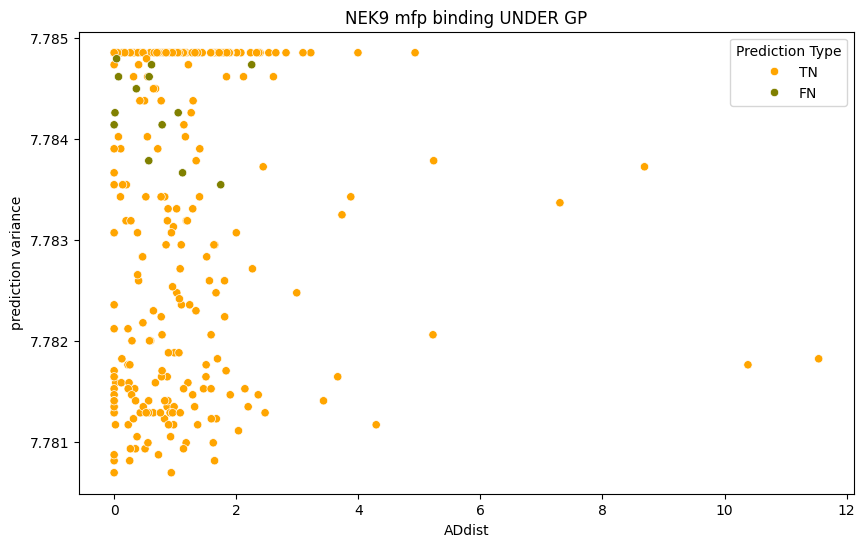

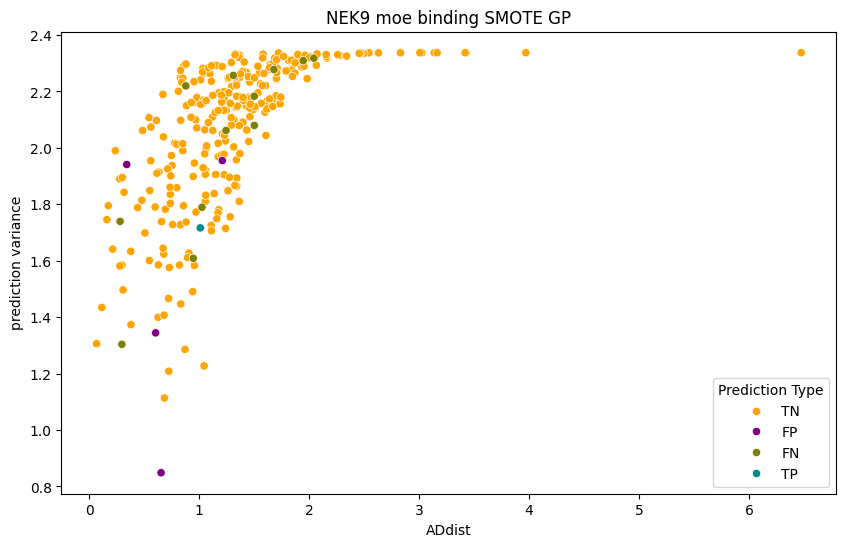

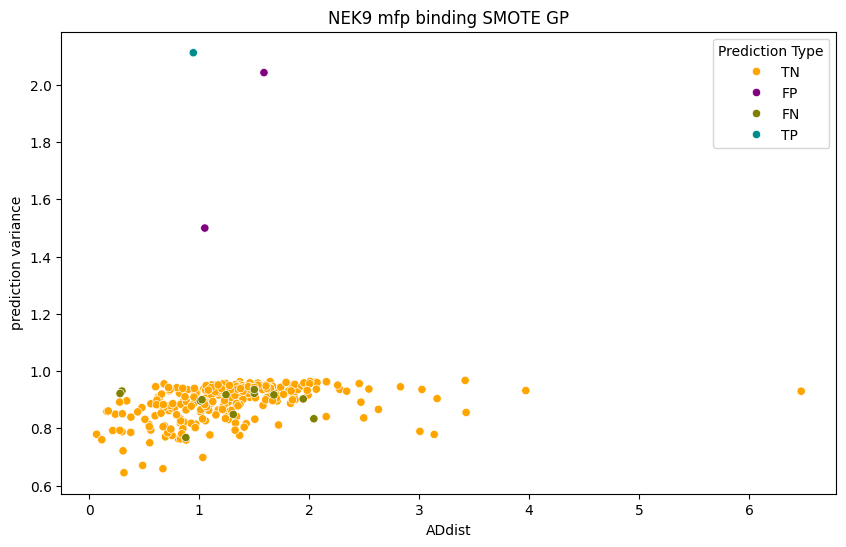

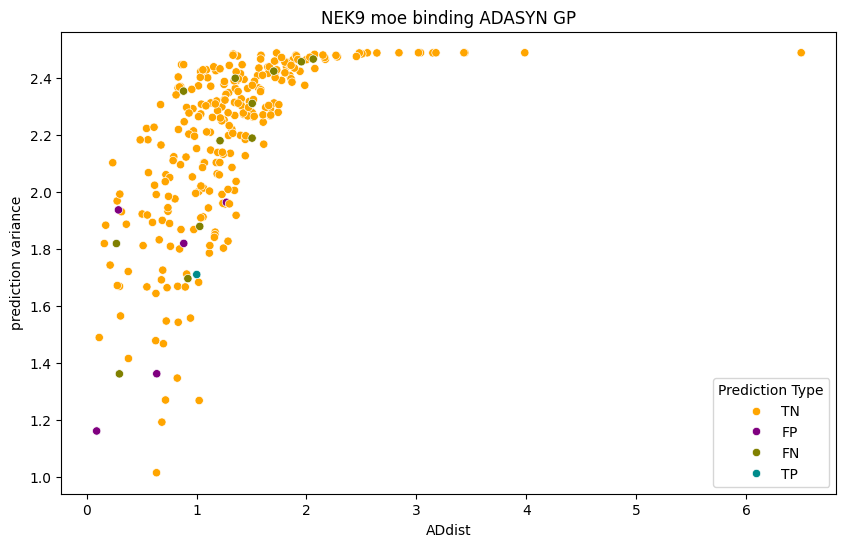

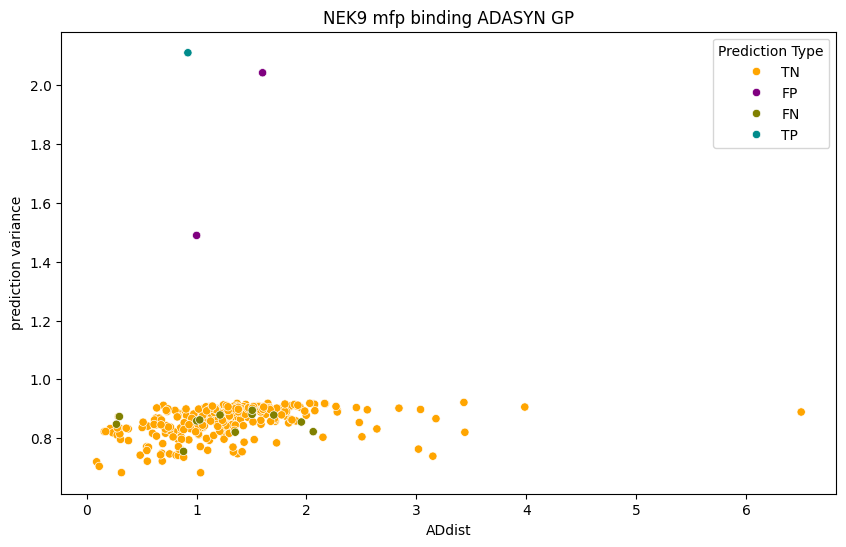

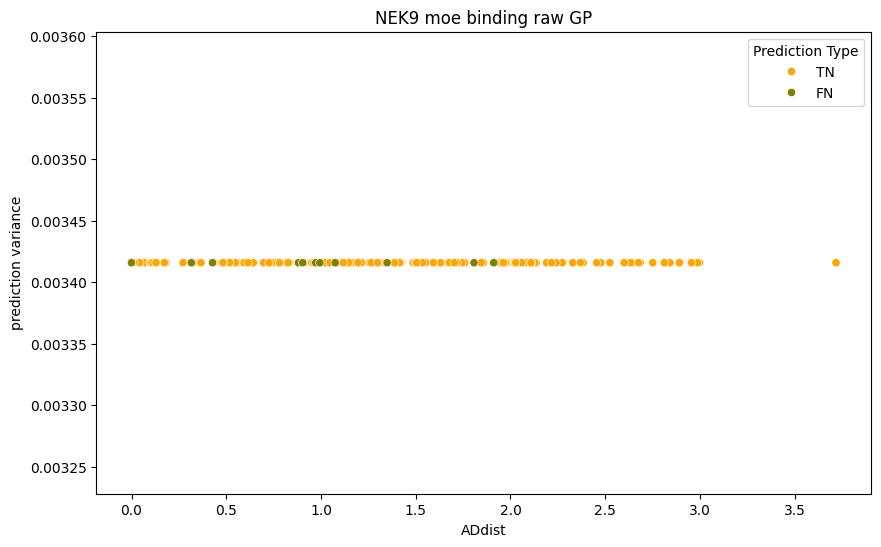

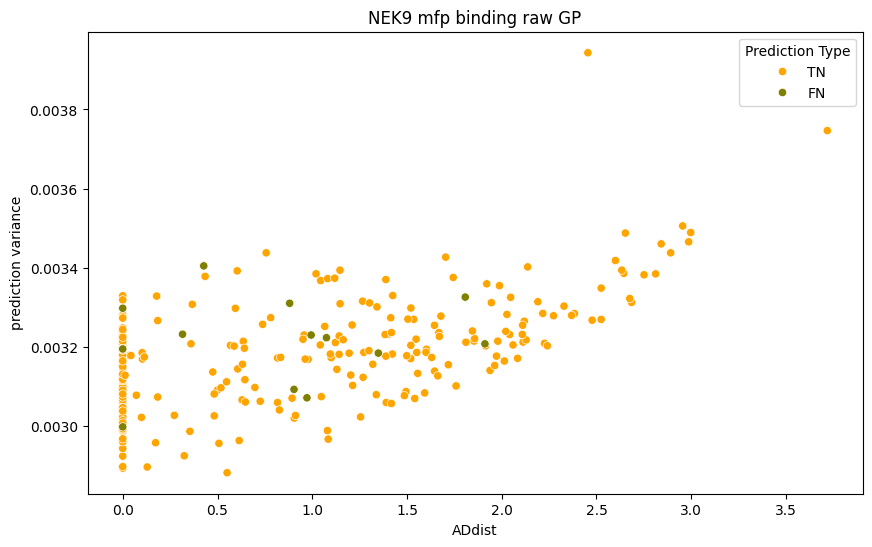

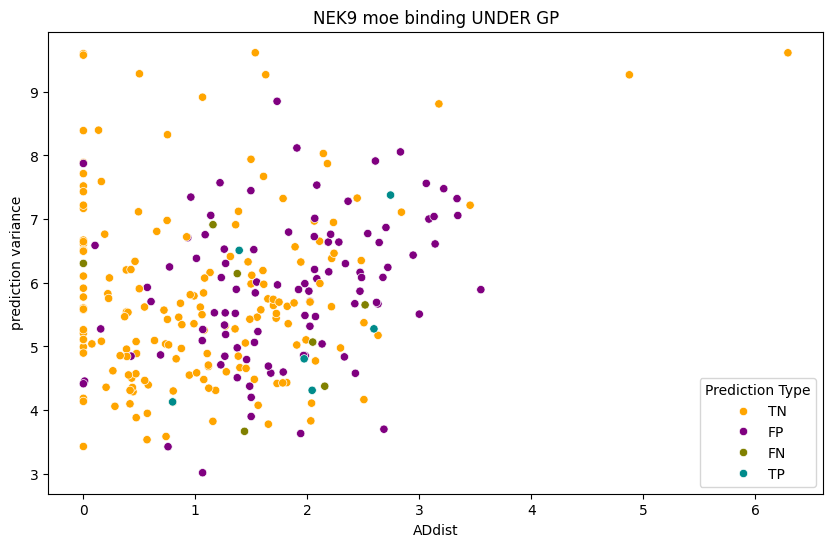

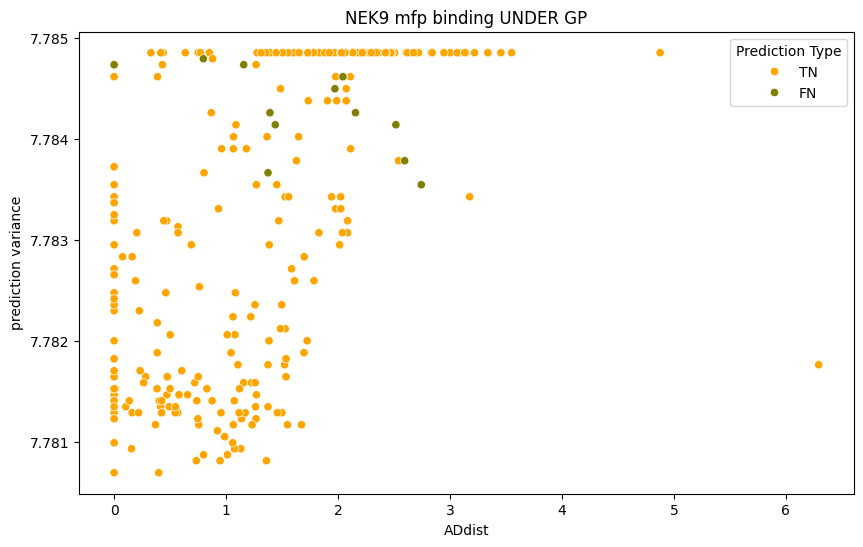

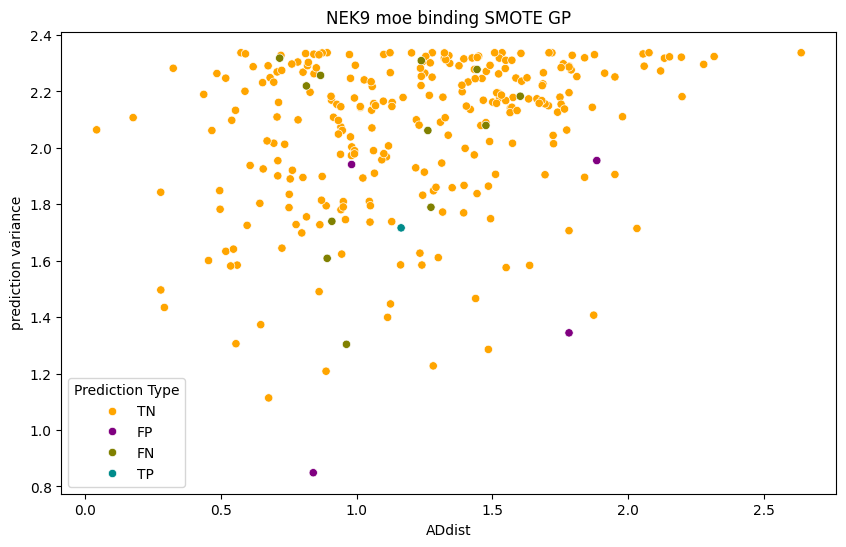

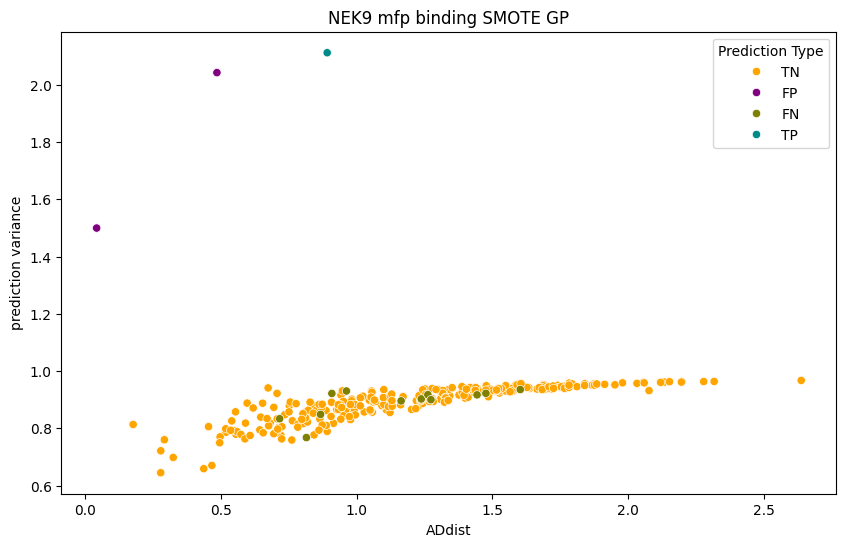

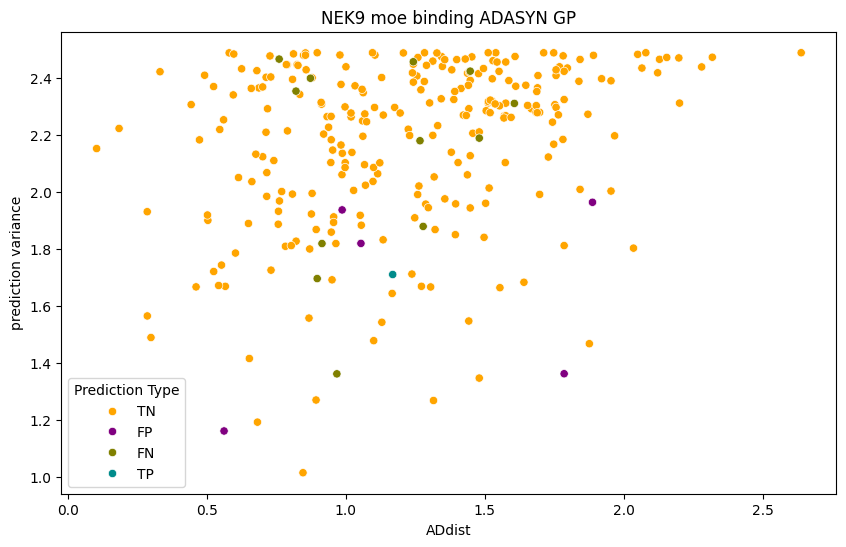

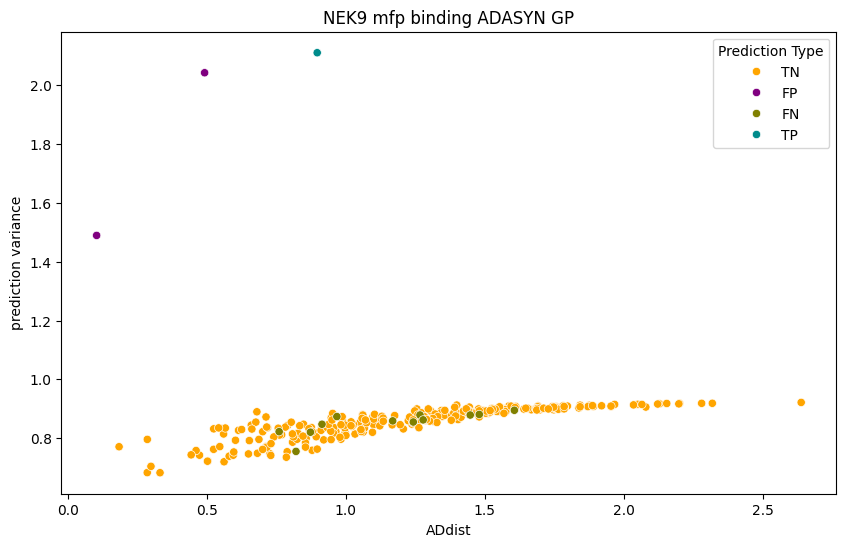

In [18]:


def scatter_ad_GP(df, true_labels, title, figure_path, filename, variance_class):
    # Determine the indices for TP, TN, FP, and FN
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    # Initialize 'Varience of prediction' with NaN
    df['prediction variance'] = np.nan
    
    # Assign values based on the indices
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    ad_dist = df['ADdist']

    # Prepare data for plotting
    data = {
        'prediction variance': df['prediction variance'],
        'Prediction Type': df['prediction_type'],
        'Feature Type': df['feat_type'],
        'ADdist' : df['ADdist']

    }
    plot_df = pd.DataFrame(data)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    pred_palette = {'TP':'darkcyan', 'TN':'orange', 'FP':'purple', 'FN':'olive'}
    ax = sns.scatterplot(x='ADdist', y='prediction variance', data=plot_df, hue='Prediction Type', palette=pred_palette)
    
  
    plt.title(title)
    plt.xlabel('ADdist')
    plt.ylabel('prediction variance')

  
        
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
col_names = ['prediction_type', 'ADdist', 'model_type']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            scatter_ad_GP(moe_df, true_labels, f'NEK{nek} moe binding {samp} GP', figure_path, f'NEK{nek}_binding_moe_{samp}_GP_AD','var0')
            scatter_ad_GP(mfp_df, true_labels, f'NEK{nek} mfp binding {samp} GP', figure_path, f'NEK{nek}_binding_mfp_{samp}_GP_AD','var0')

            if samp == 'raw': 
                samp = 'scaled'


IndexError: index 8 is out of bounds for axis 0 with size 8

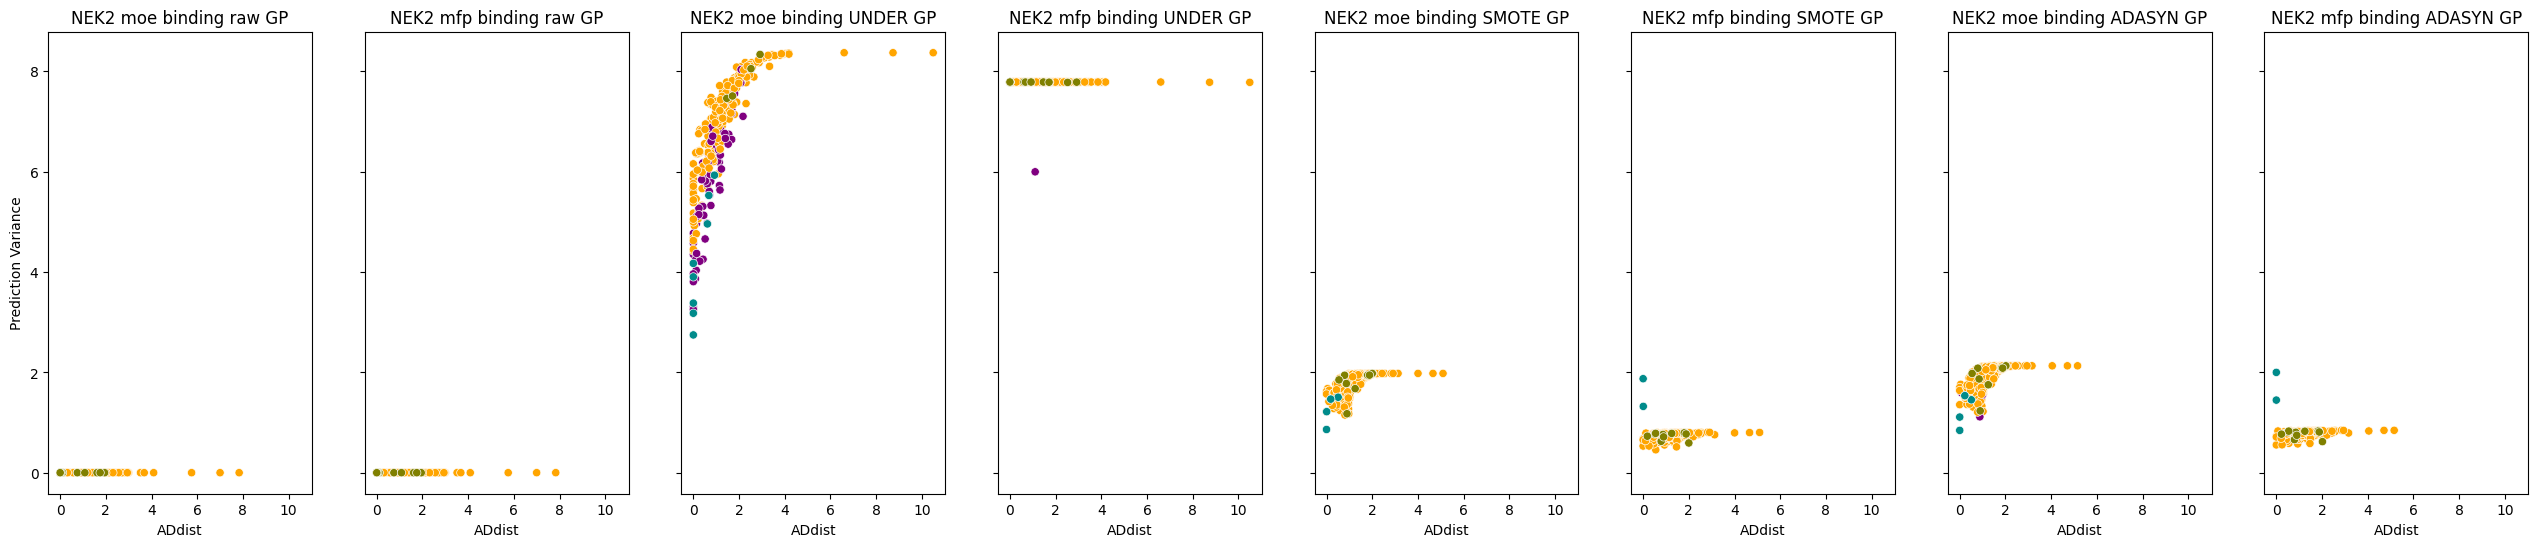

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, filename):
    fig, axes = plt.subplots(1, 8, figsize=(32, 6), sharex=True, sharey=True)
    pred_palette = {'TP': 'darkcyan', 'TN': 'orange', 'FP': 'purple', 'FN': 'olive'}
    
    for i, (df, true_labels, title) in enumerate(zip(df_list, true_labels_list, titles)):
        ax = axes[i]
        
        tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
        tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
        fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
        fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]

        df['prediction variance'] = np.nan
        df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
        df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
        df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
        df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']

        plot_df = pd.DataFrame({
            'prediction variance': df['prediction variance'],
            'Prediction Type': df['prediction_type'],
            'Feature Type': df['feat_type'],
            'ADdist': df['ADdist']
        })
        
        sns.scatterplot(x='ADdist', y='prediction variance', data=plot_df, hue='Prediction Type', palette=pred_palette, ax=ax, legend=False)
        ax.set_title(title)
        ax.set_xlabel('ADdist')
        ax.set_ylabel('Prediction Variance')
    
    plt.tight_layout()
    
    plt.show()

# Example usage:
GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    if nek == "2":  # Adjust for the specific NEK you want to plot
        df_list = []
        true_labels_list = []
        titles = []
        
        for feat in feat_types:
            for samp in samplings:
                df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv')
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                
                moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
                mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
                var0_moe = moe_pred['var_pred_class0'].to_numpy()
                var1_moe = moe_pred['var_pred_class1'].to_numpy()
                var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
                var1_mfp = mfp_pred['var_pred_class1'].to_numpy()
                moe_preds = moe_pred['y_pred']
                mfp_preds = mfp_pred['y_pred']
                true_labels = moe_pred['y'].to_numpy()

                moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
                mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
                moe_df['feat_type'] = 'moe'
                mfp_df['feat_type'] = 'mfp'

                if samp == 'scaled':
                    samp = 'raw'
                    
                df_list.extend([moe_df, mfp_df])
                true_labels_list.extend([true_labels, true_labels])
                titles.extend([
                    f'NEK{nek} moe binding {samp} GP', 
                    f'NEK{nek} mfp binding {samp} GP'
                ])

                if samp == 'raw':
                    samp = 'scaled'
        
        scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, f'NEK{nek}_{nektype}_GP_AD')
